In [3099]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.integrate as integrate
from scipy.interpolate import RBFInterpolator, InterpolatedUnivariateSpline
import scipy.special as special
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import h5py
import time
import tqdm
from typing import List, Tuple, Sequence

import os
os.chdir(os.getcwd())

In [3100]:
# N = 15       # number of loops
# lc = 0.12     # magnetic core length / m
# l = 7e-2
# w = 18e-6 * 4
N = 19       # number of loops
lc = 6.6e-2*np.pi     # magnetic core length / m
l = 7.7e-2
w = 18e-6 * 4
ur = 70000
u0 = 4* np.pi * 1e-7
u = ur * u0
Ac = l * w   # cross-sectional area / m2
fre = 4      # degauss frequency
T = 20       # deguass time
# R = 1 * 3.6 / 6  # resistance calculate
R = 1.25
gain = 15
samp_rate = 5000
n_sample = samp_rate * T
dt = 1/samp_rate

In [3101]:
def get_data(fname,off_set):
    Vin = []
    Vpick = []
    for i in off_set:
        with h5py.File(fname, "a") as f:
            dset = f[f"{i}off"]
            Vin.append(dset[0])
            Vpick.append(dset[1])
    return np.array(Vin[0]),np.array(Vpick[0])

def get_general_data(fname,rname,off_set):
    Vin = []
    Vpick = []
    with h5py.File(fname, "a") as f:
        dset = f[rname]
        Vin.append(dset[0])
        Vpick.append(dset[1])
    return np.array(Vin[0]),np.array(Vpick[0])

def get_off(fname,runname = "off"):
    off_set = []
    off_get = []
    with h5py.File(fname, "a") as f:
        dset = f[runname]
        off_set.append(dset[0])
        off_get.append(dset[1])
    return np.array(off_set[0]), np.array(off_get[0])

def off_fit(off_set,off_get):
    coef = np.polyfit(off_set, off_get, 1)
    poly1d_fn = np.poly1d(coef) 
    return poly1d_fn

def test_func(x, a ,b, c,d):
    return a * np.exp(-b*x) * np.sin(c *2*np.pi* x + d)

def expdcysin_fit(raw_data, Vset,time_stamp, fre, time_factor):
    # x_data = np.linspace(0 , 1/fre, len(raw_data))
    x_data = time_stamp
    y_data = raw_data
    params, params_covariance = optimize.curve_fit(test_func, x_data, y_data,p0=[Vset,1,time_factor*fre,0])
    plt.plot(x_data, y_data,"-", label='Data')
    plt.plot(x_data, test_func(x_data, params[0], params[1],params[2],params[3]),"-",label='Fitted function',color = "r")
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    return params, x_data

def off_subtract(Vin,Vpick,off_set,fitfun):
    input_off_fit = fitfun(off_set)/1000/3.6
    input_off_mea = np.mean(Vin[-10000:-1])
    print(input_off_mea)
    print(input_off_fit)
    Vin_sub = Vin - input_off_mea
    pick_off_mea = np.mean(Vpick[-10000:-1])
    Vpick_sub = Vpick - pick_off_mea
    return Vin_sub, Vpick_sub

In [3102]:
file_name = "C:\\Users\\CeNTREX\\Documents\\GitHub\\new_cavity\\degauss_4_2_2024.hdf"
off_file_name = "off_set.hdf"
off = [0]
V_off = 150
run_name = "noamp9Vpp4Hz" + str(V_off) + "off1kHz"
#Vpick, Vin = get_data(file_name,off)   # get both input voltage and pickup voltage
Vin, Vpick = get_general_data(file_name,run_name,off)
time_stamp = np.linspace(0,T,len(Vin))
off_set, off_get = get_off(off_file_name)        # get offset calibration measured before
off_fit_fun = off_fit(off_set, off_get) 

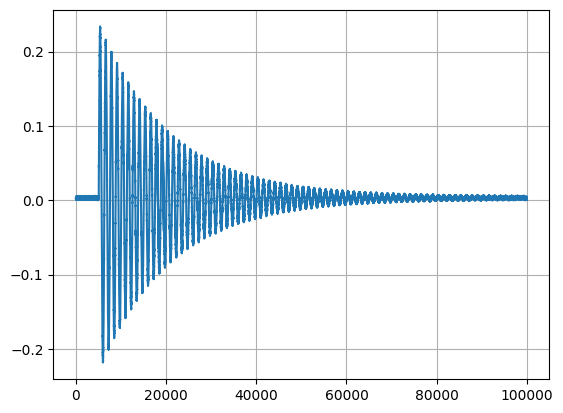

In [3103]:
plt.plot(Vin)
plt.grid(True)

In [3104]:
pos_peaks,_ = find_peaks(Vpick,distance=1000, height = max(Vpick)-0.2)
neg_peaks,_ = find_peaks(-Vpick,distance=1000, height = max(Vpick)-0.2)
print(pos_peaks[0:4])
print(neg_peaks[0:4])
print(neg_peaks[1] - pos_peaks[0])
print(pos_peaks[1] - neg_peaks[1])
time_used = time_stamp[pos_peaks[1]:-10000]
Vin_used  = Vin[pos_peaks[1]:-10000] 
Vpick_used = Vpick[pos_peaks[1]:-10000]
Vin_mea, Vpick_mea = off_subtract(Vin_used,Vpick_used,off[0],off_fit_fun)
# Vin_mea = Vin_used
# Vpick_mea = Vpick_used
I = Vin_mea /R
H = np.array(I) * N / lc

[5087 6341 7593 8845]
[5721 6974 8226 9479]
1887
-633
0.0030656802160926814
7.588888888888942e-05


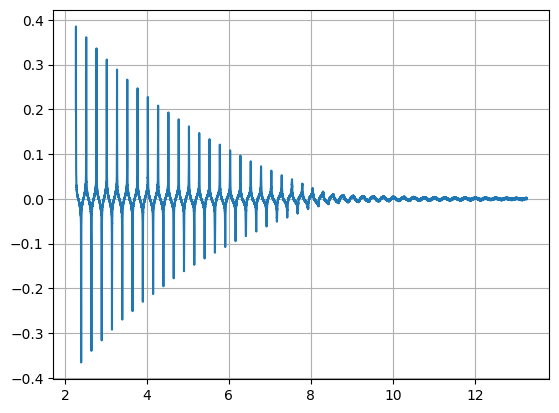

In [3105]:
start = 5000
stop = 60000
m = np.s_[start:stop]
plt.plot(time_used[m],Vpick_mea[m])
plt.grid(True)

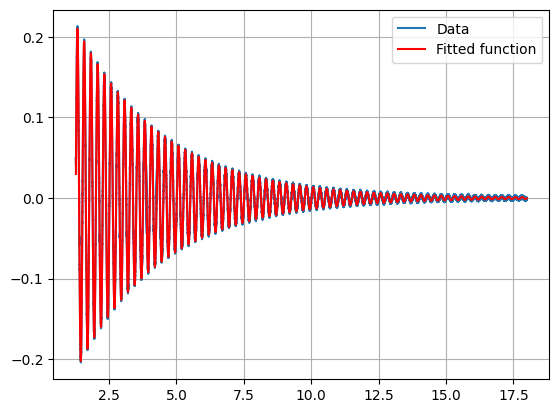

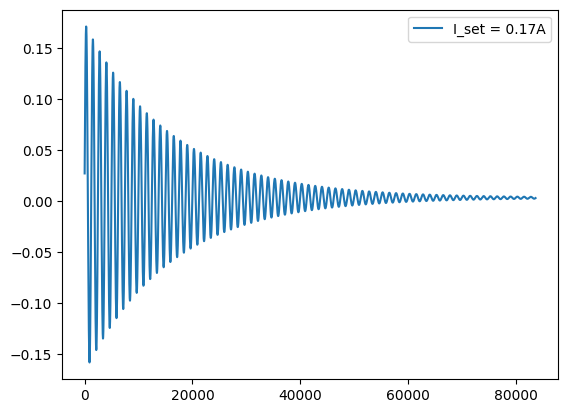

In [3106]:
amp_fit = []
derate_fit = []
fre_fit = []
phase_fit = []
V_SGamp = []
Vamp = 4.25 * 2 
param,x = expdcysin_fit(Vin_mea,Vamp,time_used,4,1)
amp_fit.append(param[0])
derate_fit.append(param[1])
fre_fit.append(param[2])
phase_fit.append(param[3])
# if param[0] > 0:
#     V_SGamp.append((2 * Vamp - 2*abs(param[0]))/2)
# else:
#     V_SGamp.append((-1* (2 * Vamp - 2*abs(param[0])))/2)

data_fit = test_func(x,param[0] , param[1],param[2],param[3])
V_SGamp = (2 * Vamp - max(abs(data_fit)))/2
convert_factor = V_SGamp / max(abs(data_fit))
I = []
I_set = np.array(Vamp)/50
V_SG = data_fit * convert_factor + V_off/1000
I= (V_SG)/50
plt.plot(I, label  = "I_set = "+ str(I_set) + "A")
plt.legend()

In [3122]:
B = []
B_int = []
Bini = [0]
Vini = [0]
dB = np.array(Vpick_mea)/Ac/N/gain
#print("magnetic field difference between pos & neg peak:",dB[pos_peaks[0]] + dB[neg_peaks[0]] )
print(len(dB))
H = np.array(I) * N / lc
for a in dB[0:-1]:
        Bini.append(Bini[-1] + (a+0.025)* dt )
B.append(Bini)

83659


Text(0, 0.5, 'B (T)')

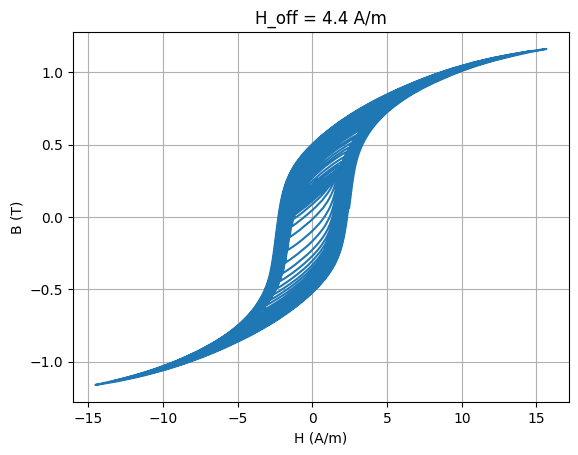

In [3123]:
start = 0000
stop = 80000
m = np.s_[start:stop]
plt.plot(H[m],B[0][m]-(max(B[0])+min(B[0]))/2,"-")
#plt.plot(H[m],np.array(B[0][m]),"-")
plt.grid(True)
plt.title("H_off = 4.4 A/m")
plt.xlabel("H (A/m)")
plt.ylabel("B (T)")

Text(0, 0.5, 'B (T)')

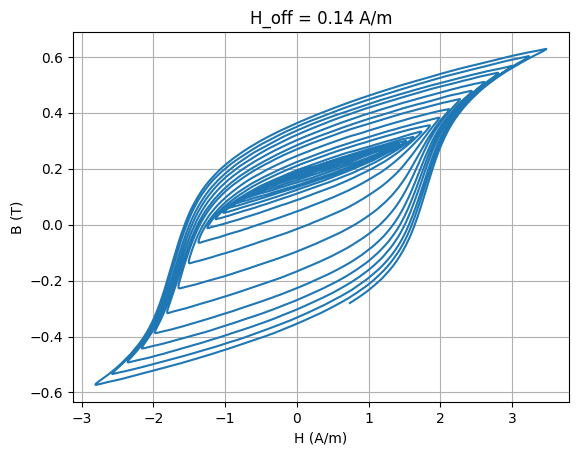

In [3124]:
start = 25000
stop = 50000
m = np.s_[start:stop]
plt.plot(H[m],B[0][m]-(max(B[0])+min(B[0]))/2,"-")
#plt.plot(H[m],np.array(B[0][m]),"-")
plt.grid(True)
plt.title("H_off = 0.14 A/m")
plt.xlabel("H (A/m)")
plt.ylabel("B (T)")

C:\Users\CeNTREX\AppData\Roaming\Python\Python311\site-packages\IPython\core\displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


Text(0, 0.5, 'B (T)')

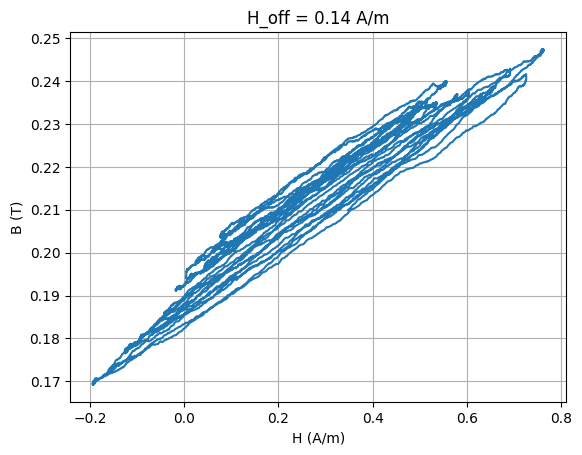

In [3125]:
start = 55000
stop = 70000
m = np.s_[start:stop]
plt.plot(H[m],B[0][m]-(max(B[0])+min(B[0]))/2,"-")
#plt.plot(H[m],np.array(B[0][m])+0.2,"-")
plt.grid(True)
plt.title("H_off = 0.14 A/m")
plt.xlabel("H (A/m)")
plt.ylabel("B (T)")

[-3.67168179 -2.75376134 -1.65225681 -1.28508863 -0.91792045 -0.73433636
 -0.55075227 -0.36716818 -0.27537613 -0.18358409 -0.09179204  0.
  0.09179204  0.18358409  0.27537613  0.36716818  0.55075227  0.73433636
  0.91792045  1.28508863  1.65225681  2.38659316  3.67168179]


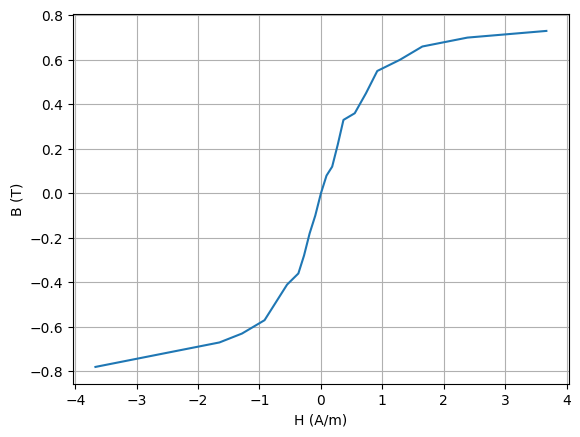

In [3126]:
# off =[-3,-2,-1.5,-0.9,-0.7,-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4,0.5,0.7,0.9,1.3,2,2.9]
off =[-2,-1.5,-0.9,-0.7,-0.5,-0.4,-0.3,-0.2,-0.15,-0.1,-0.05,0,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.7,0.9,1.3,2]
H_off = np.array(off) / convert_factor / R * N /lc
print(H_off)
#B_settle = [-0.83,-0.78,-0.77,-0.67,-0.63,-0.57,-0.49,-0.41,-0.36,-0.18,0,0.12,0.33,0.36,0.45,0.55,0.6,0.66,0.7,0.73,0.76]
B_settle = [-0.78,-0.73,-0.67,-0.63,-0.57,-0.49,-0.41,-0.36,-0.28,-0.18,-0.1,0,0.08,0.12,0.22,0.33,0.36,0.45,0.55,0.6,0.66,0.7,0.73]
plt.plot(H_off,B_settle)
plt.xlabel("H (A/m)")
plt.ylabel("B (T)")
plt.grid(True)

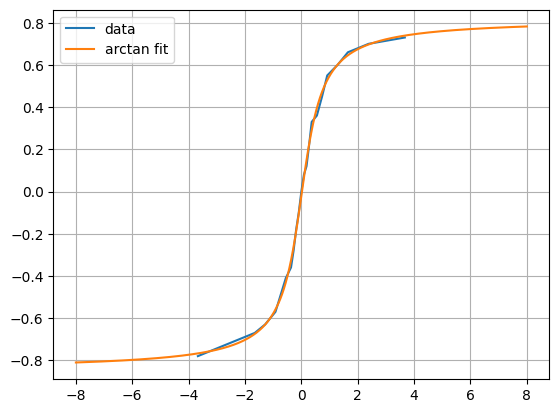

In [3133]:
# Defining parametrized arctangent function
def f(x, k, w, x0, y0):
    return k * np.arctan(w*(x-x0)) + y0

output = curve_fit(f, H_off, np.array(B_settle), full_output=True)
copt = output[0]
H_fit = np.linspace(-8,8,1000)
dH = H_fit[1] - H_fit[0]
B_fit = f(H_fit,*copt)
u_fit = np.gradient(B_fit,dH)/u0
plt.plot(H_off,B_settle,label = "data")
plt.plot(H_fit,f(H_fit,*copt),label = "arctan fit")
plt.legend()
plt.grid(True)

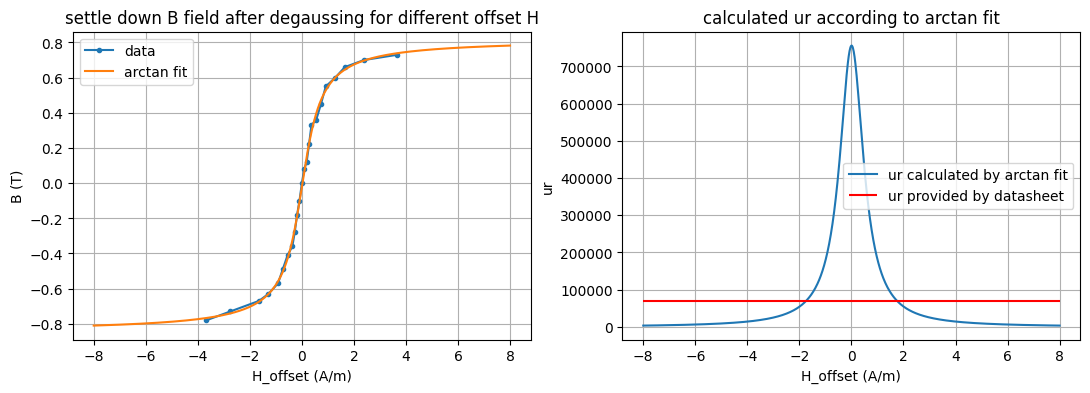

In [3134]:
fig,ax = plt.subplots(1,2,figsize=(13, 4))
ax[0].plot(H_off,B_settle,".-",label = "data")
ax[0].plot(H_fit,f(H_fit,*copt),label = "arctan fit")
ax[0].set_xlabel("H_offset (A/m)")
ax[0].set_ylabel("B (T)")
ax[0].set_title("settle down B field after degaussing for different offset H")
ax[1].plot(H_fit,u_fit, label = "ur calculated by arctan fit")
ax[1].hlines(xmin = -8, xmax = 8 , y = 70000,color = "r",label = "ur provided by datasheet")
ax[1].set_xlabel("H_offset (A/m)")
ax[1].set_ylabel("ur")
ax[1].set_title("calculated ur according to arctan fit")
ax[0].grid(True)
ax[1].grid(True)
ax[0].legend()
ax[1].legend()